In [ ]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/j7zymbjelxlf4v5meujq32s27bbirf')
labels=['Positive', 'Neutral', 'Negative', 'Highly positive', 'Highly negative']
percent=0.3
sentiment_counts=df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].value_counts()
for i in range(len(labels)):
  df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==labels[i]]=df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==labels[i]].nlargest(int(percent*sentiment_counts[i]),'which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence')
df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].value_counts()
labels=['Highly positive', 'Positive', 'Neutral', 'Negative', 'Highly negative']

In [ ]:
import os
os.mkdir('/content/images')
directories=['train','valid','test']
for directory in directories:
  os.mkdir('/content/images/'+directory)
  for j, label in enumerate(labels):
    os.mkdir('/content/images/'+directory+'/'+str(j))

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=37bb264909be01dfa4fb225186bbcdd0d77f68b07b5a07f25596bbea7a30350b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import threading
import wget

def download_img(url,directory,label,i):
  try:
    wget.download(url, '/content/images/'+directory+'/'+label+'/img'+i+'.jpg', )
  except:
    pass
for i, label in enumerate(labels):
  urls = df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==label]['imageurl']
  n1_split=int(len(urls)*0.8)
  n2_split=int(len(urls)*0.95)
  n=0
  for j, url in enumerate(urls):
    if n<n1_split:
      directory=directories[0]
    elif n<n2_split:
      directory=directories[1]
    else:
      directory=directories[2]
    threading.Thread(target=download_img, args= (url,directory,str(i),str(j),)).start()
    n+=1

In [ ]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

TRAIN_DATA_PATH = "/content/images/train/"
VALID_DATA_PATH = "/content/images/valid/"
TEST_DATA_PATH = "/content/images/test/"
DATA_TRANSFORM = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])
BATCH_SIZE = 32
train_data=datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=DATA_TRANSFORM)
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data=datasets.ImageFolder(root=VALID_DATA_PATH, transform=DATA_TRANSFORM)
valid_dl = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_data=datasets.ImageFolder(root=TEST_DATA_PATH, transform=DATA_TRANSFORM)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


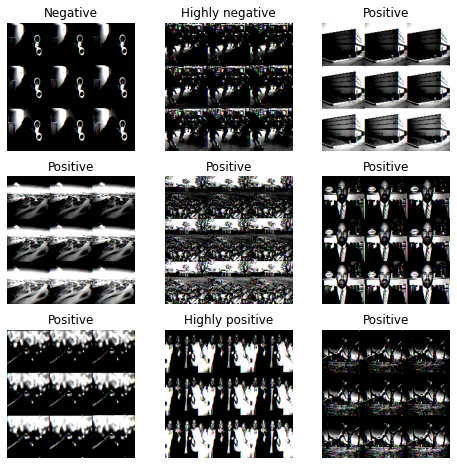

In [ ]:
import matplotlib.pyplot as plt
X_test, Y_test = iter(test_dl).next()
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.title(labels[Y_test[i]])
    plt.axis("off")
    plt.imshow(X_test[i].reshape(224,224,3))
plt.show()

In [ ]:
import torch
import torchvision
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
'https://drive.google.com/file/d/1-415NKay-f0X_u24EyebySYEUZ3ClTz-/view?usp=sharing'

In [ ]:
for p in model.parameters():
    p.requires_grad = False

out_dim = 5
model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, out_dim))

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model.pth'))
model.to(device)

In [ ]:
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0005
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import f1_score

def eval_model(classes: int):
  X_true, Y_true = iter(test_dl).next()
  model.eval()
  X_true, Y_true = X_true.to(device), Y_true.to(device)
  Xvl = X_true
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_true)

  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_true.cpu(), Y_pred.cpu(), average='macro')

  acc = sum(Y_true == Y_pred)/len(Y_pred)

  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true.cpu(), Y_pred.cpu())
  lclasses = labels
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()
  print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

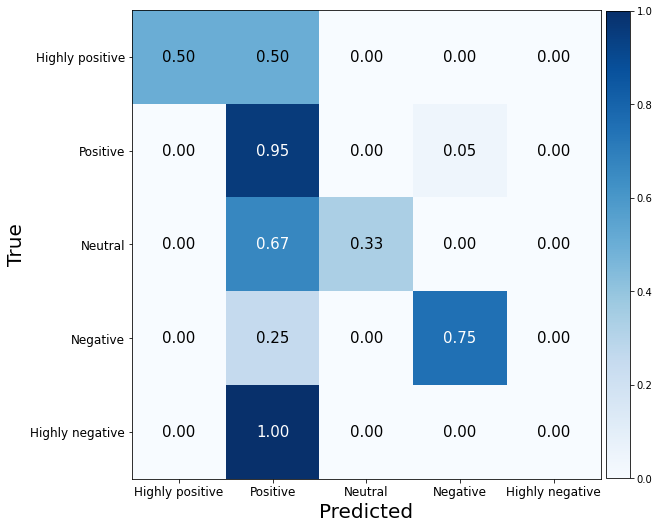

Loss:0.87, F1:0.56, Acc:0.81


In [ ]:
eval_model(classes=5)